# Hourly PSDS - FFBI & ROMY (U,V,Z)

## Load Libraries

In [1]:
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from numpy import logspace, linspace, log, log10, isinf, ones, nan, count_nonzero, sqrt, isnan
from pandas import DataFrame, concat, Series, date_range, read_csv, read_pickle
from tqdm import tqdm
from pathlib import Path

import os, sys
import pickle
import matplotlib.pyplot as plt

from andbro__querrySeismoData import __querrySeismoData
from andbro__savefig import __savefig

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [3]:
## ---------------------------------------


name = "FFBI"  ## "WROMY_WS7"
inname = "2023_FFBI_3600"  ## "2023_WROMY_WS7_3600"
subdir = "FFBI_absolute/"  ## "WROMY_WS7/"
threshold = 8e-1
f_limits = 1/1600, 1.0

d1, d2 = "2023-09-23", "2023-10-23"


## ---------------------------------------

path = data_path+f"LNM2/PSDS/"

## load configurations
config = pickle.load(open(path+subdir+inname+"_config.pkl", 'rb'))

config['inname'] = inname
config['inpath'] = path+subdir
config['f_limits'] = f_limits
config['thres'] = threshold
config['station'] = name

config['outpath_figures'] = data_path+f"LNM2/figures/"

config['frequency_limits'] = [config['f_limits'][0], config['f_limits'][1]]


In [4]:
!ls /import/kilauea-data/LNM2/PSDS/IROMY

2023_IROMY_3600_20230813_hourly.pkl  2023_IROMY_3600_20230818_hourly.pkl
2023_IROMY_3600_20230814_hourly.pkl  2023_IROMY_3600_20230819_hourly.pkl
2023_IROMY_3600_20230815_hourly.pkl  2023_IROMY_3600_20230820_hourly.pkl
2023_IROMY_3600_20230816_hourly.pkl  2023_IROMY_3600_config.pkl
2023_IROMY_3600_20230817_hourly.pkl  2023_IROMY_3600_frequency_axis.pkl


In [5]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero

    min_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])

    return min_psd

In [6]:
def __get_median_psd(psds):

    from numpy import median, zeros, isnan

    med_psd = zeros(psds.shape[1])

    for f in range(psds.shape[1]):
        a = psds[:,f]
        med_psd[f] = median(a[~isnan(a)])

    return med_psd

In [7]:
def __get_minimum_psd(psds, f_tmp):

    for i, psd in enumerate(psds):
        if i == 0:
            lowest_value = psd.sum()
            idx = 0

        value = psd.sum()

        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i

    return psds[idx]

In [8]:
def __get_array_from_dataframe(df):

    from pandas import to_numeric

    ## convert to list
    psds = []
    for col in array(df.columns):

        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

## Methods

In [9]:
def __filter_psds(psds, thresholds):

    from numpy import mean, array

    psds_filtered = []
        ## filter mean psds values
#         m_psd = mean(psd)
#         if m_psd > thresholds[0] and m_psd < thresholds[1]:
#             psds_filtered.append(psd)

    ## filter for periods larger than 20 seconds
    if mean(psd[0:63]) < thresholds[0]:
        psds_filtered.append(psd)

    print(f" -> removed {len(psds)- len(psds_filtered)} of {len(psds)} psds due to thresholds: {thresholds[0]} & {thresholds[1]}")
    return array(psds_filtered)

In [10]:
def __load_data_file(path, file):

    from tqdm.notebook import tqdm
    from numpy import array

    psds_all = []
    psds_hourly = read_pickle(path+file)

    for psd in psds_hourly:
        psds_all.append(psd)

    return array(psds_all)

In [11]:
def __cut_frequencies_array(arr, freqs, fmin, fmax):

    ind = []
    for i, f in enumerate(freqs):
        if f >= fmin and f <= fmax:
            ind.append(i)

    ff = freqs[ind[0]:ind[-1]]
    pp = arr[:,ind[0]:ind[-1]]

    return pp, ff

In [18]:
def __remove_noisy_psds(arr, threshold_mean=1e-16, ff=None, flim=None):

    from numpy import delete, shape, sort, array, ones, nan

    if flim is not None and ff is not None:
        for n, f in enumerate(ff):
            if f > flim:
                idx_max = n
                break

    idx_min = 5

    l1 = shape(arr)[0]

    idx_to_remove = []
    rejected = []
    for ii in range(shape(arr)[0]):

        ## appy upper threshold
        if flim is not None and ff is not None:
            if arr[ii, idx_min:idx_max].mean() > threshold_mean:
                if ii == 0:
                    print(f" -> filter threshold between {round(ff[idx_min],4)} and {round(ff[idx_max],2)}")
                rejected.append(arr[ii, :])
                arr[ii] = ones(len(arr[ii])) * nan
                # idx_to_remove.append(ii)
        else:
            if arr[ii, :].mean() > threshold_mean:
                rejected.append(arr[ii, :])
                idx_to_remove.append(ii)

        ## apply default lowe threshold
        if arr[ii, :].mean() < 1e-26:
            rejected.append(arr[ii, :])
            idx_to_remove.append(ii)

    # for jj in sort(array(idx_to_remove))[::-1]:
    #     arr = delete(arr, jj, axis=0)

    l2 = shape(arr)[0]

    print(f" -> removed {l1-l2} rows due to mean thresholds!")
    print(f" -> {l2} psds remain")

    return arr, rejected

In [19]:
def __makeplot_colorlines(config, ff, psds, rejected, day):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)

    ##____________________________

    fig, axes = plt.subplots(1, 1, figsize=(15,7), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = 24
    colors = plt.cm.rainbow(linspace(0, 1, N))
    cmap = plt.get_cmap('rainbow', 24)

    for n, psd in enumerate(psds):
        axes.loglog(ff, psd, color=colors[n], alpha=0.7)
        p2 = axes.scatter(ff[0], psd[0], s=0.1, c=int(n/N), cmap=cmap, vmin=0, vmax=N)

    for reject in rejected:
         axes.loglog(ff, reject, color='grey', alpha=0.6, zorder=1)

    axes.loglog(ff, __get_median_psd(psds), 'black', zorder=3, alpha=0.6, label="Median")

    axes.grid(True, which="both", ls="-", alpha=0.5)
    axes.legend(loc='lower left')
    axes.tick_params(labelsize=font-2)

#     axes.set_ylim(1e-23, 1e-16)

    axes.set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)


    axes.set_ylabel(r"PSD$_{vertical}$ (m$^2$/s$^4$/$Hz)$", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes, aspect=50, pad=-1e-5,
                       ticks=arange(1,N,2))


    plt.show();
    return fig

In [20]:
def __makeplot_colorlines_overview(config, ff, psds, rejected, day, show_rejected=True):

    from tqdm.notebook import tqdm
    from numpy import isnan, median, mean, std, array, zeros
    from scipy.stats import median_abs_deviation as mad

#     psds_median = __get_median_psd(array(psds))
#     psds_minimal = __get_minimal_psd(array(psds))
#     psds_minimum = __get_minimum_psd(array(psds), ff)


    # ## convert frequencies to periods
    # pp=[]
    # for mm in range(len(ff)):
    #     ppp = zeros(len(ff[mm]))
    #     ppp = 1/ff[mm]
    #     pp.append(ppp)


    ##____________________________

    NN = 4

    fig, axes = plt.subplots(NN, 1, figsize=(12, 10), sharey=False, sharex=True)

    plt.subplots_adjust(hspace=0.1)

    font = 14

    N = 24

    colors = plt.cm.rainbow(linspace(0, 1, N))
    cmap = plt.get_cmap('rainbow', 24)


    for j in range(NN):

        try:
            for n, psd in enumerate(psds[j]):
                axes[j].loglog(ff[j], psd, color=colors[n], alpha=0.7)
                p2 = axes[j].scatter(ff[j][0], psd[0], s=0., c=n/N, cmap=cmap, vmin=0, vmax=N, zorder=3)

            if show_rejected:
                for reject in rejected[j]:
                     axes[j].loglog(ff[j],reject, color='grey', alpha=0.6, zorder=2)
        except:
            continue

        axes[j].loglog(ff[j], __get_median_psd(psds[j]), 'black', zorder=3, alpha=0.6, label="Median")

        axes[j].set_xlim(config['frequency_limits'][0], config['frequency_limits'][1])
        axes[j].grid(True, which="both", ls="-", alpha=0.5)
        axes[j].legend(loc='lower left')
        axes[j].tick_params(labelsize=font-2)

    ## limits of sensor noise
    # freq = arange(0.0001, 1, 0.001)
    # plim1 = 0.1**2 * ones(len(freq)) / 12 / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2 = 0.1**2 * ones(len(freq)) / 12/ (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # plim1_1 = 0.1**2 * ones(len(freq)) / (0.5*0.1) ## resolution = 0.1 hPa @ 0.1Hz sampling
    # plim2_1 = 0.1**2 * ones(len(freq)) / (0.5*1.0) ## resolution = 0.1 hPa @ 0.1Hz sampling

    # axes[1].loglog(freq, plim1, color="black", ls="--", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2, color="black", ls="--", zorder=4, alpha=0.7)

    # axes[1].loglog(freq, plim1_1, color="black", ls=":", zorder=4, alpha=0.7)
    # axes[2].loglog(freq, plim2_1, color="black", ls=":", zorder=4, alpha=0.7)


    axes[NN-1].set_xlabel("  Frequency (Hz)", fontsize=font, labelpad=-1)

    ## panel labels
    axes[0].text(.01, .95, '(a)', ha='left', va='top', transform=axes[0].transAxes, fontsize=font)
    axes[1].text(.01, .95, '(b)', ha='left', va='top', transform=axes[1].transAxes, fontsize=font)
    axes[2].text(.01, .95, '(c)', ha='left', va='top', transform=axes[2].transAxes, fontsize=font)
    axes[3].text(.01, .95, '(c)', ha='left', va='top', transform=axes[3].transAxes, fontsize=font)

    axes[0].text(.05, .95, 'ROMY-Z', ha='left', va='top', transform=axes[0].transAxes, fontsize=font)
    axes[1].text(.05, .95, 'ROMY-V', ha='left', va='top', transform=axes[1].transAxes, fontsize=font)
    axes[2].text(.05, .95, 'ROMY-U', ha='left', va='top', transform=axes[2].transAxes, fontsize=font)
    axes[3].text(.05, .95, 'FFBI', ha='left', va='top', transform=axes[3].transAxes, fontsize=font)

    axes[0].set_title(day, fontsize=font+2)

    axes[0].set_ylim(bottom=1e-23, top=1e-17)
    axes[1].set_ylim(bottom=1e-23, top=1e-17)
    axes[2].set_ylim(bottom=1e-23, top=1e-17)

    axes[0].set_ylabel(r"PSD (rad$^2$/s$^4$/Hz)", fontsize=font)
    axes[1].set_ylabel(r"PSD (rad$^2$/s$^4$/Hz)", fontsize=font)
    axes[2].set_ylabel(r"PSD (rad$^2$/s$^4$/Hz)", fontsize=font)
    axes[3].set_ylabel(r"PSD (hPa$^2$/Hz)", fontsize=font)

    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='vertical', ax=axes.ravel().tolist(), aspect=50, pad=-1e-5,
                       ticks=arange(1,N,2))


    plt.show();
    return fig

## RUN for all files 

 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


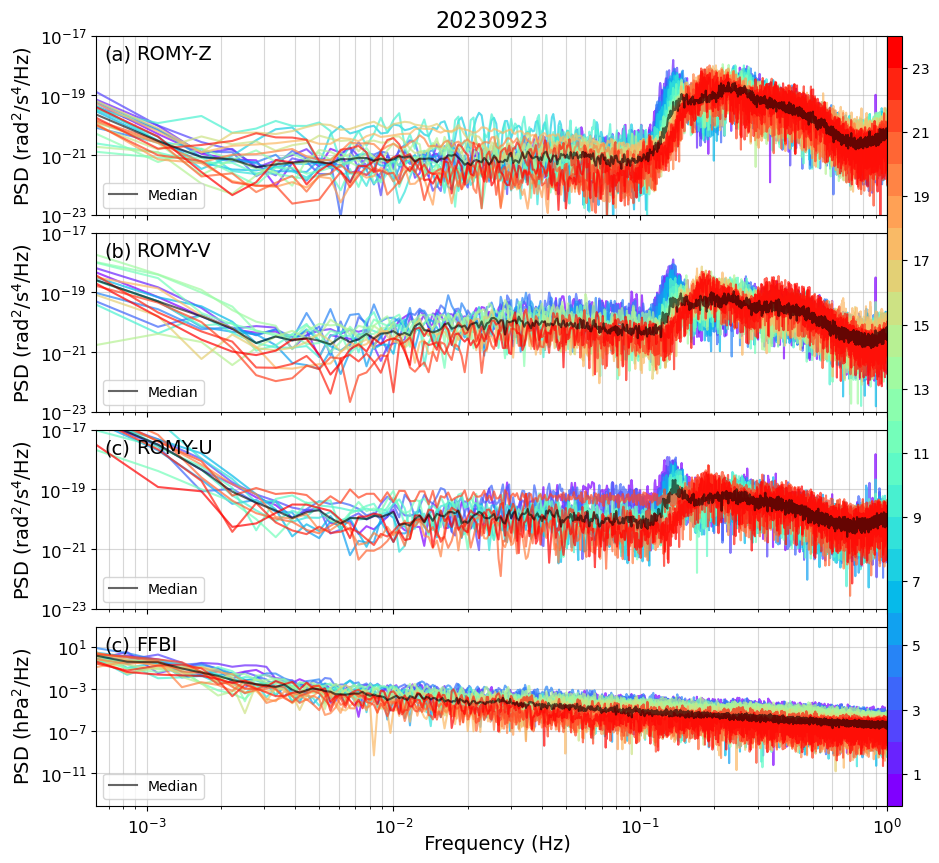

 -> saving: /import/kilauea-data/LNM2/figures/joint_20230923.png
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


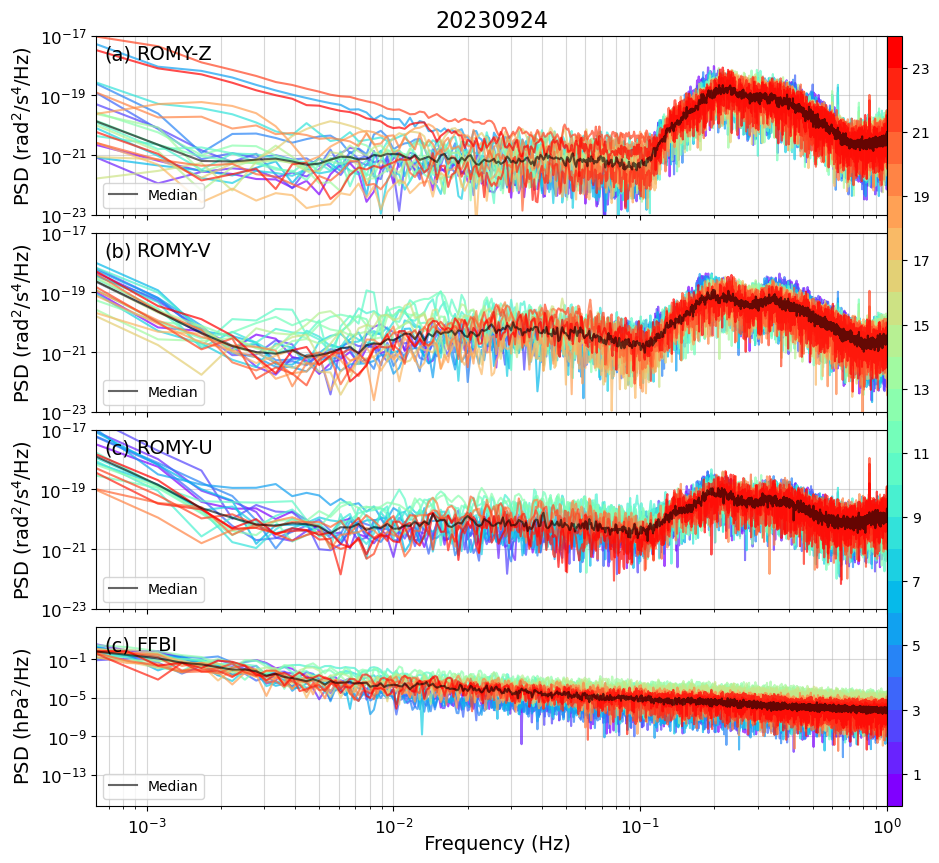

 -> saving: /import/kilauea-data/LNM2/figures/joint_20230924.png
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


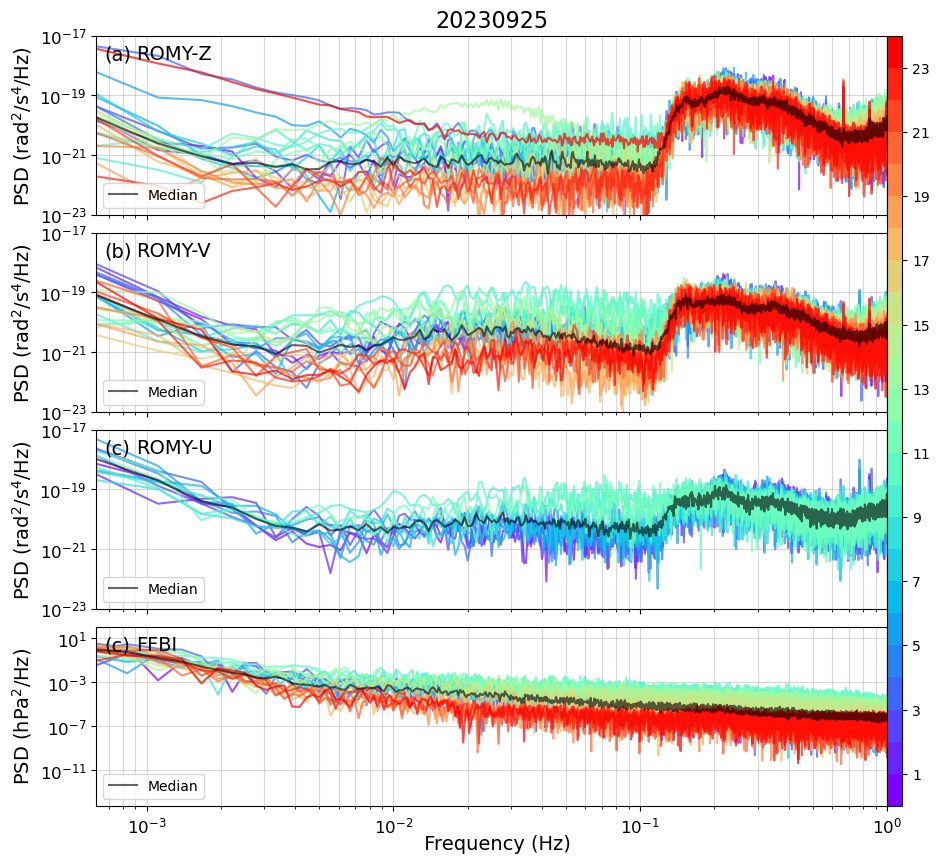

 -> saving: /import/kilauea-data/LNM2/figures/joint_20230925.png
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> filter threshold between 0.0028 and 0.05
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


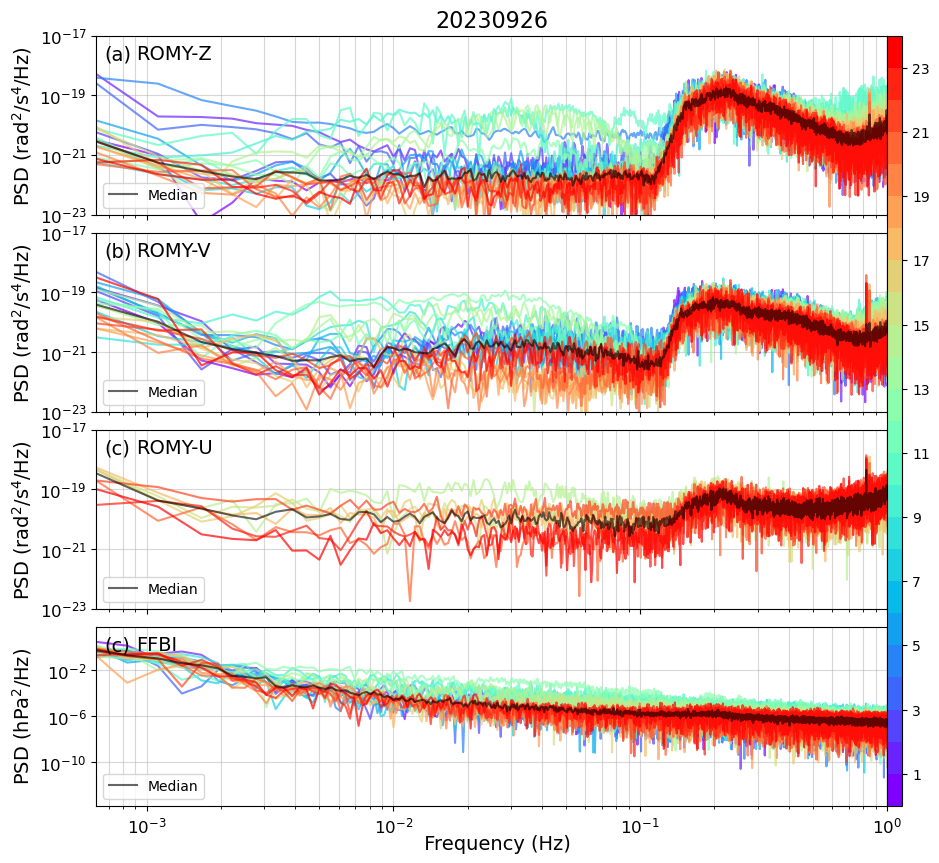

 -> saving: /import/kilauea-data/LNM2/figures/joint_20230926.png
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


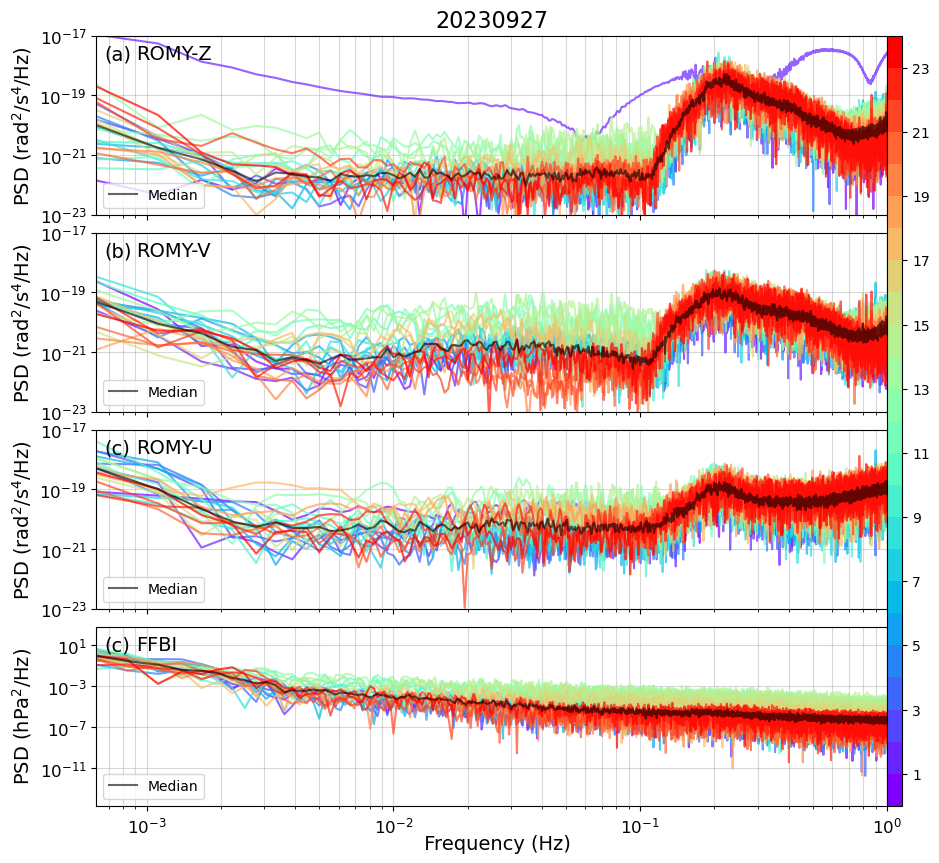

 -> saving: /import/kilauea-data/LNM2/figures/joint_20230927.png
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


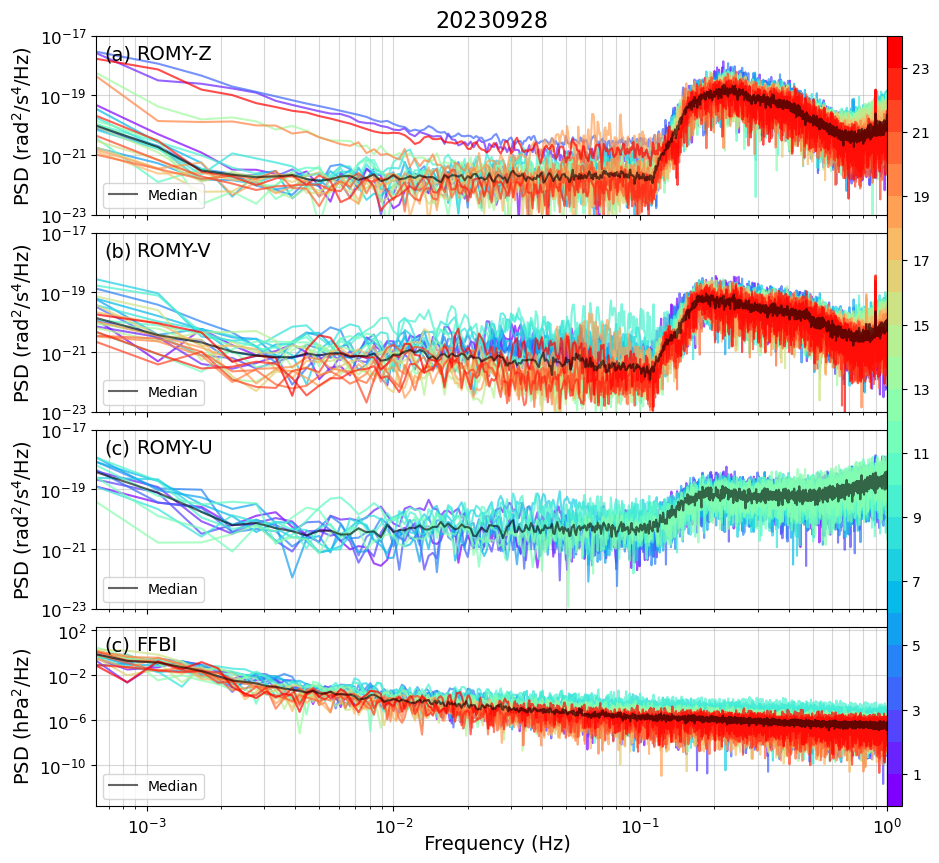

 -> saving: /import/kilauea-data/LNM2/figures/joint_20230928.png
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> filter threshold between 0.0028 and 0.05
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


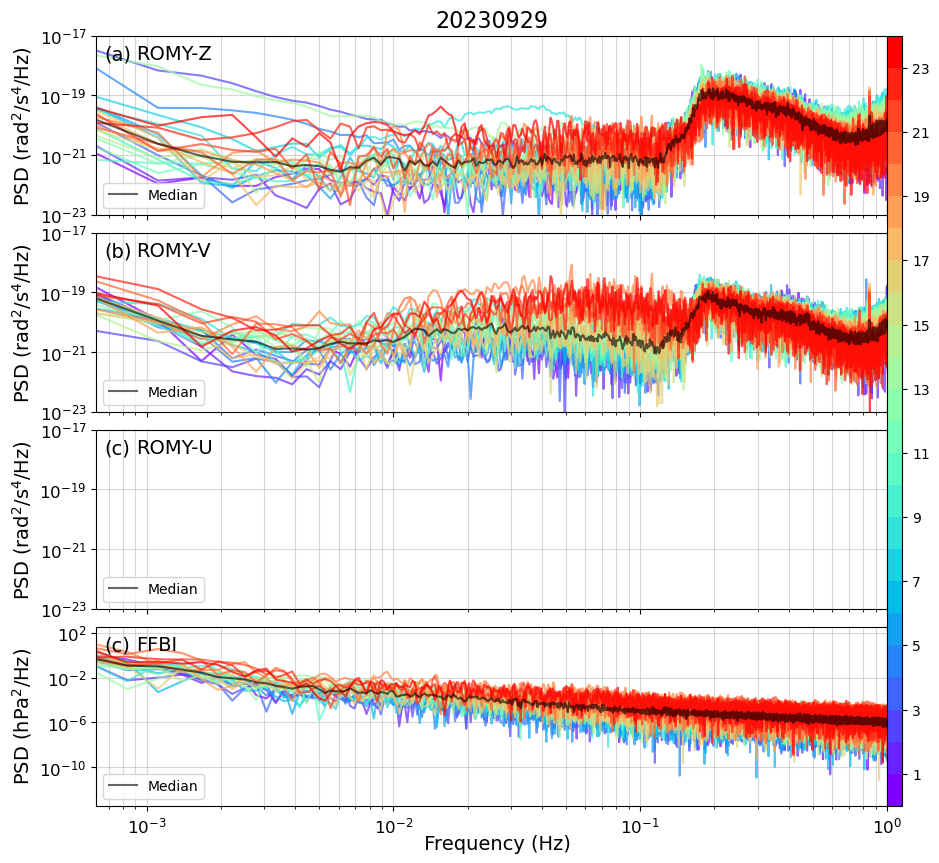

 -> saving: /import/kilauea-data/LNM2/figures/joint_20230929.png
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> filter threshold between 0.0028 and 0.05
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


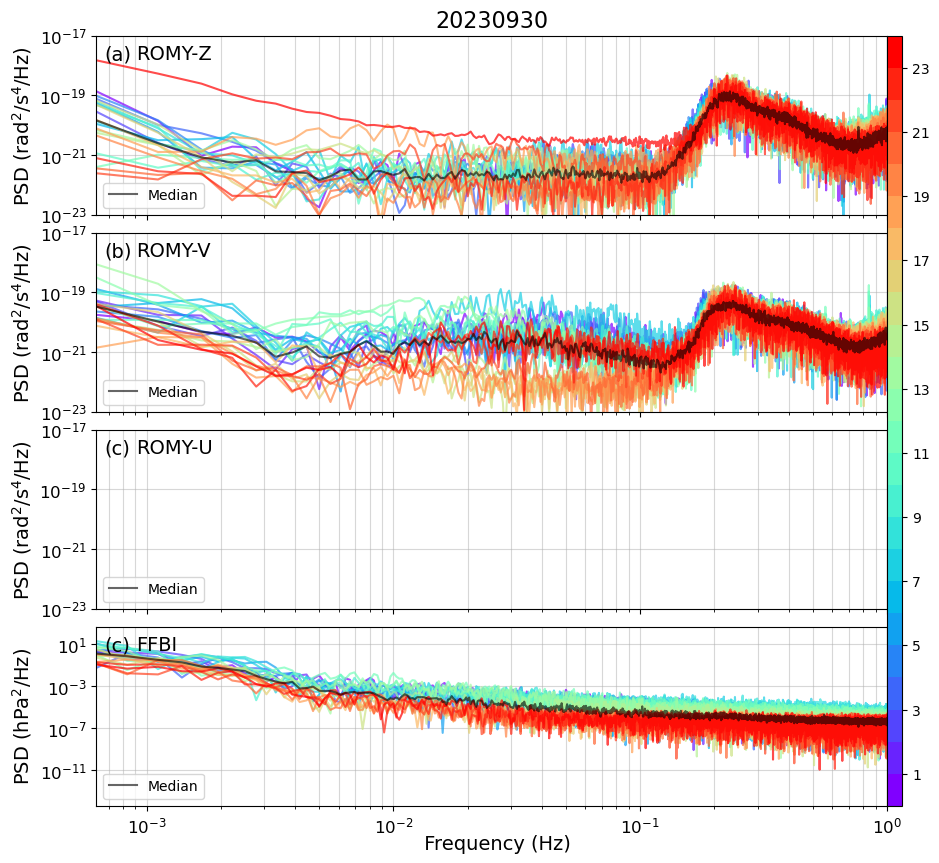

 -> saving: /import/kilauea-data/LNM2/figures/joint_20230930.png
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> filter threshold between 0.0028 and 0.05
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


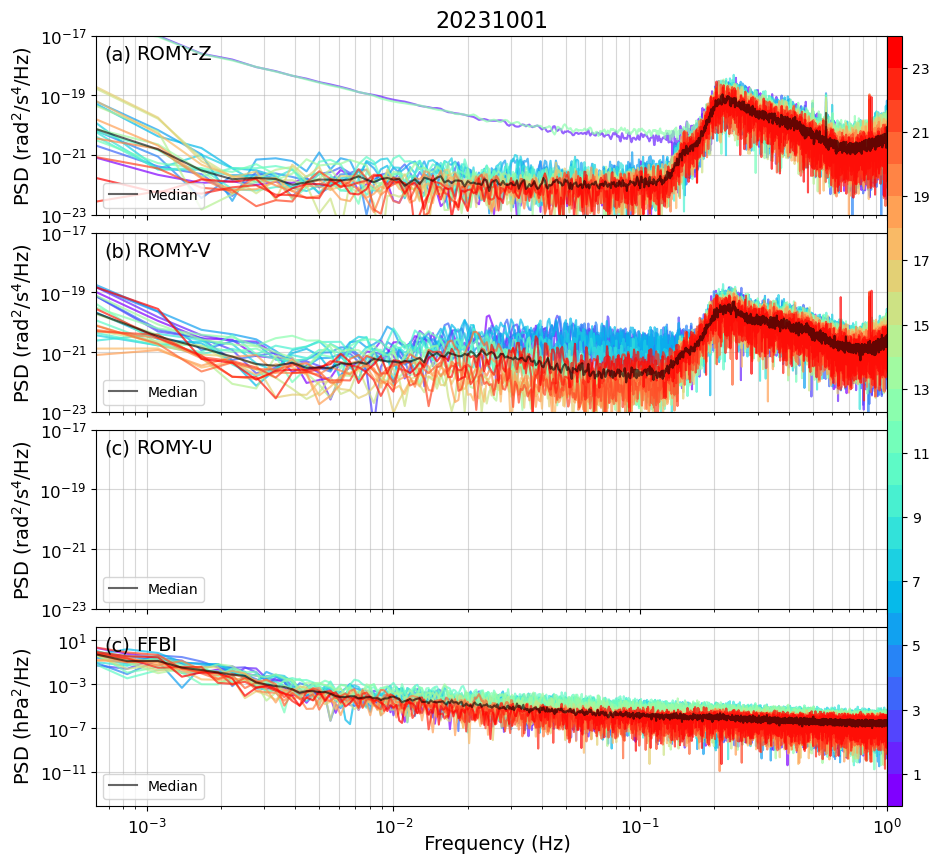

 -> saving: /import/kilauea-data/LNM2/figures/joint_20231001.png
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> filter threshold between 0.0028 and 0.05
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


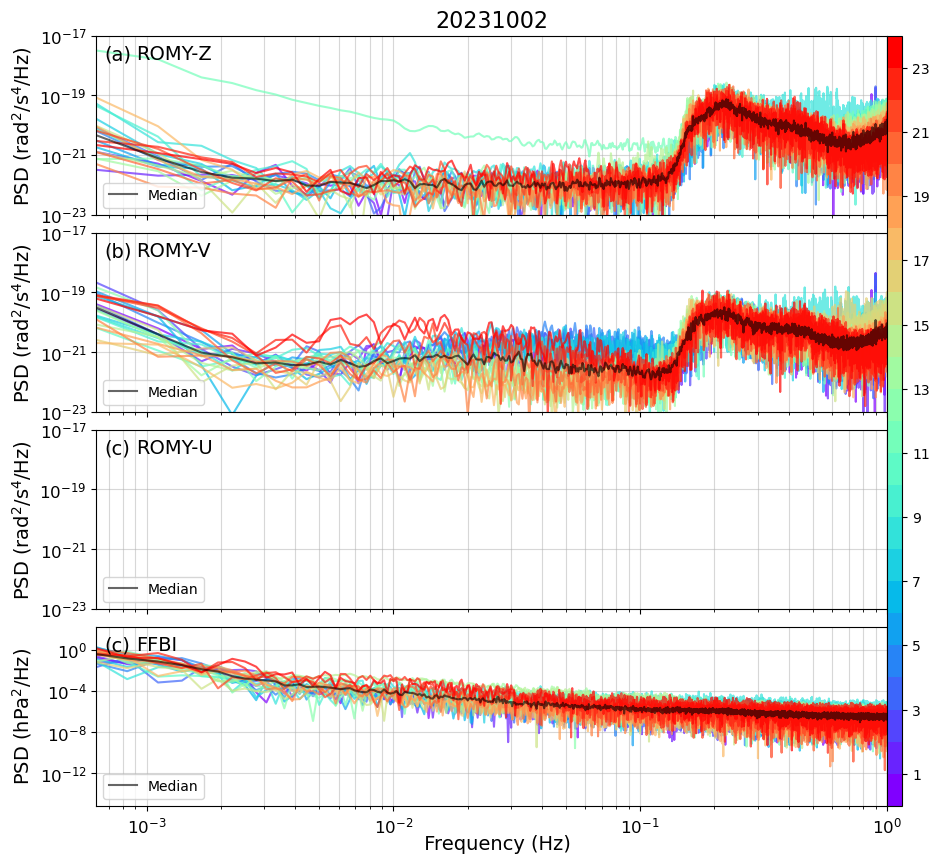

 -> saving: /import/kilauea-data/LNM2/figures/joint_20231002.png
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> filter threshold between 0.0028 and 0.05
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


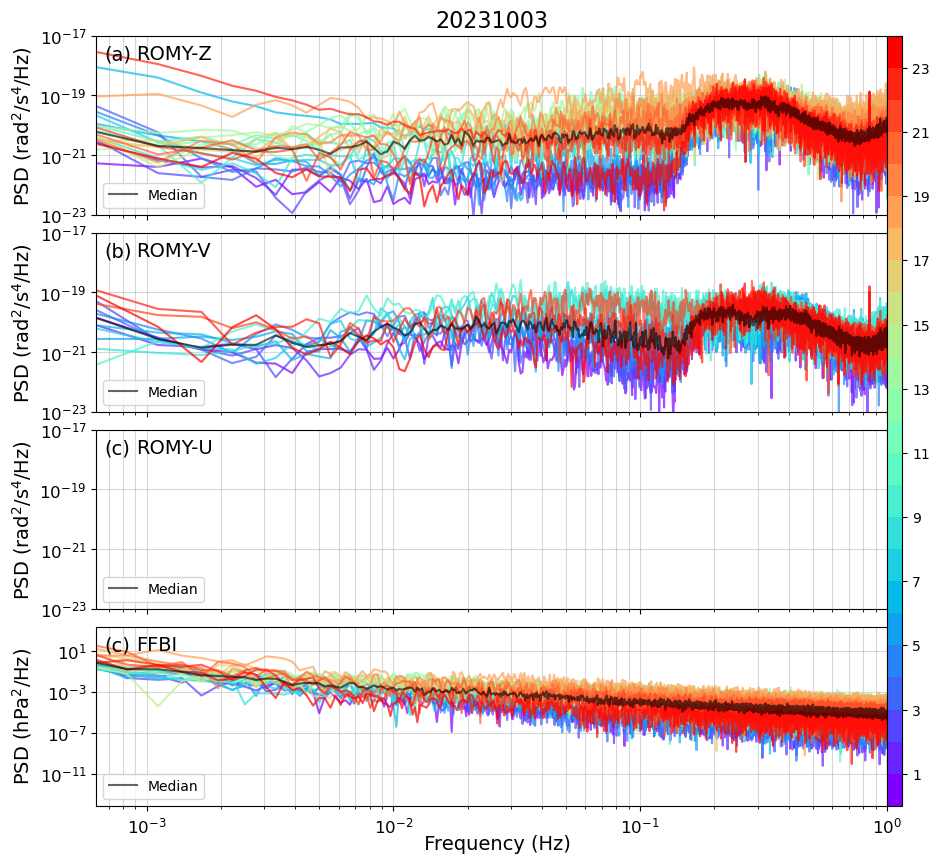

 -> saving: /import/kilauea-data/LNM2/figures/joint_20231003.png
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> filter threshold between 0.0028 and 0.05
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


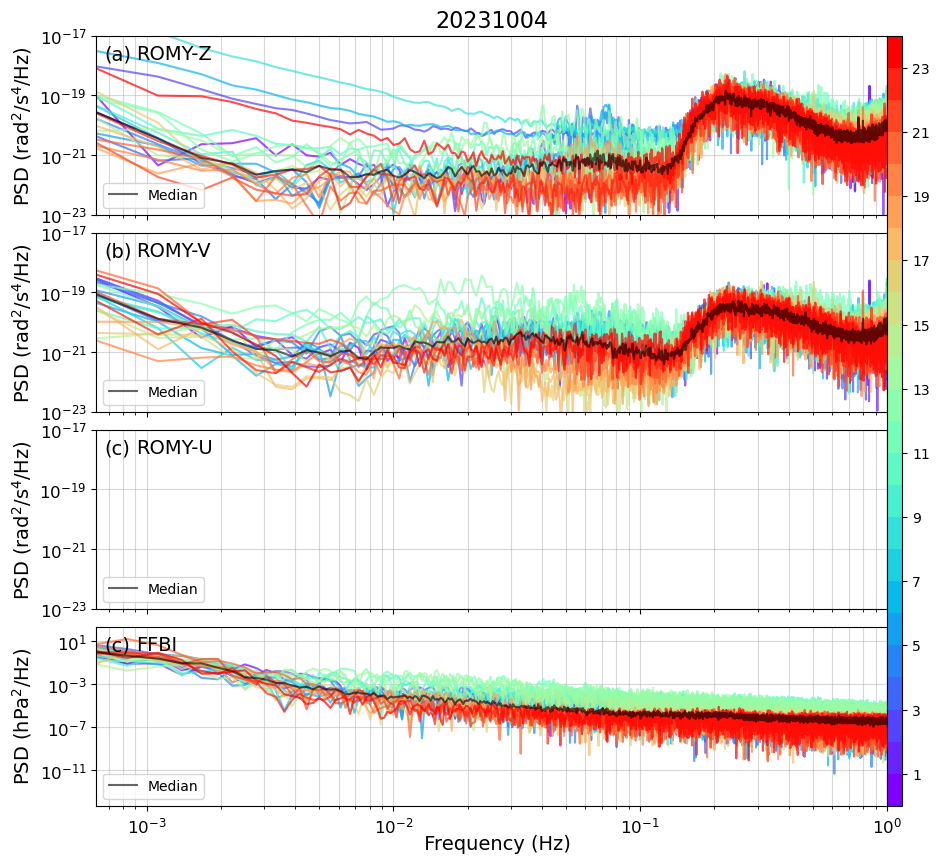

 -> saving: /import/kilauea-data/LNM2/figures/joint_20231004.png
[Errno 2] No such file or directory: '/import/kilauea-data/LNM2/PSDS/ROMY/2023_ROMY_Z_3600_20231005_hourly.pkl'
[Errno 2] No such file or directory: '/import/kilauea-data/LNM2/PSDS/ROMY/2023_ROMY_Z_3600_20231006_hourly.pkl'
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
[Errno 2] No such file or directory: '/import/kilauea-data/LNM2/PSDS/ROMY/2023_ROMY_U_3600_20231007_hourly.pkl'
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
[Errno 2] No such file or directory: '/import/kilauea-data/LNM2/PSDS/ROMY/2023_ROMY_U_3600_20231008_hourly.pkl'
[Errno 2] No such file or directory: '/import/kilauea-data/LNM2/PSDS/ROMY/2023_ROMY_Z_3600_20231009_hourly.pkl'
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
[Er

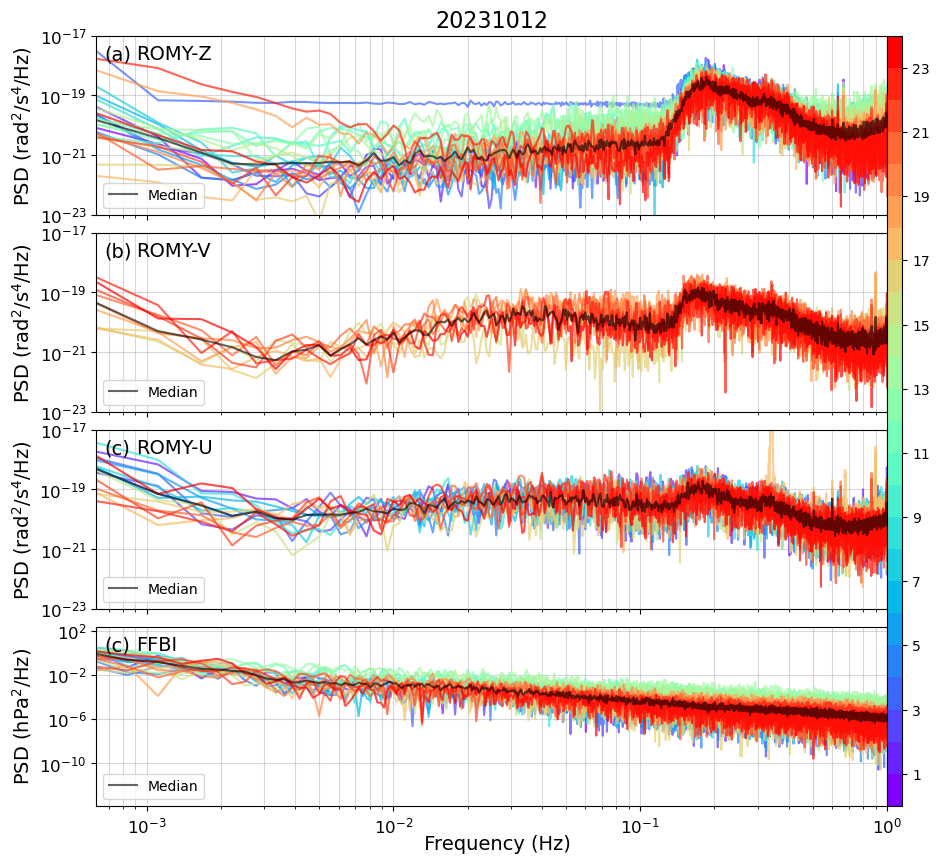

 -> saving: /import/kilauea-data/LNM2/figures/joint_20231012.png
[Errno 2] No such file or directory: '/import/kilauea-data/LNM2/PSDS/ROMY/2023_ROMY_Z_3600_20231013_hourly.pkl'
 -> filter threshold between 0.0028 and 0.05
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> filter threshold between 0.0028 and 0.05
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


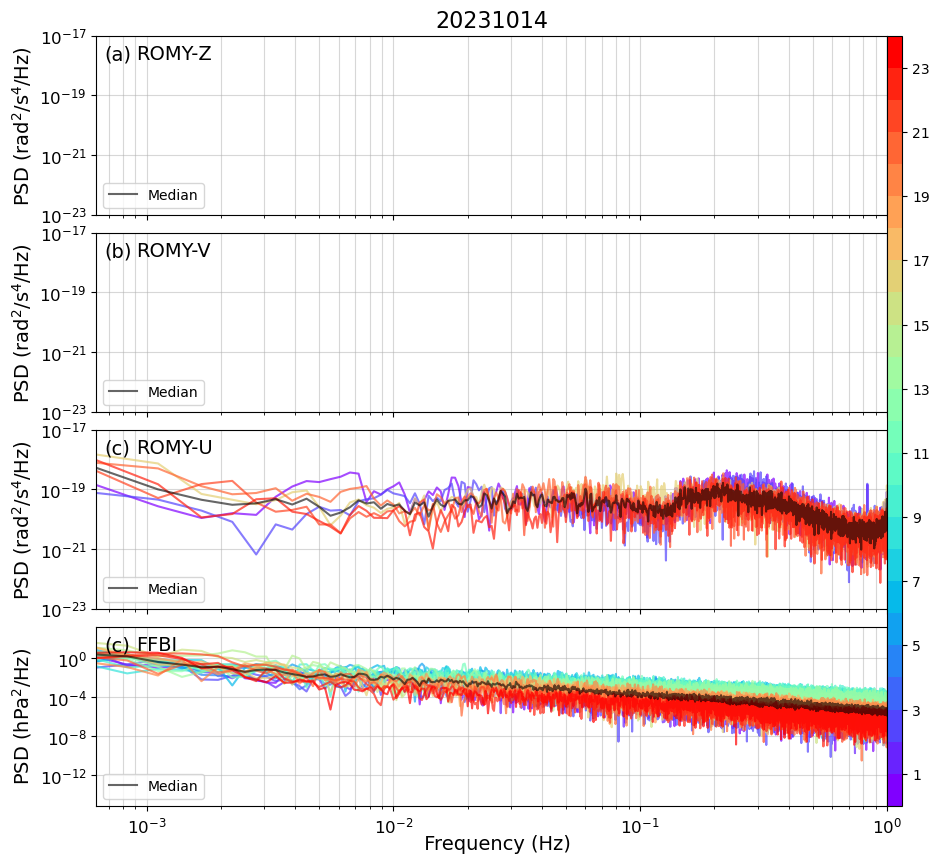

 -> saving: /import/kilauea-data/LNM2/figures/joint_20231014.png
 -> filter threshold between 0.0028 and 0.05
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> filter threshold between 0.0028 and 0.05
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain


/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


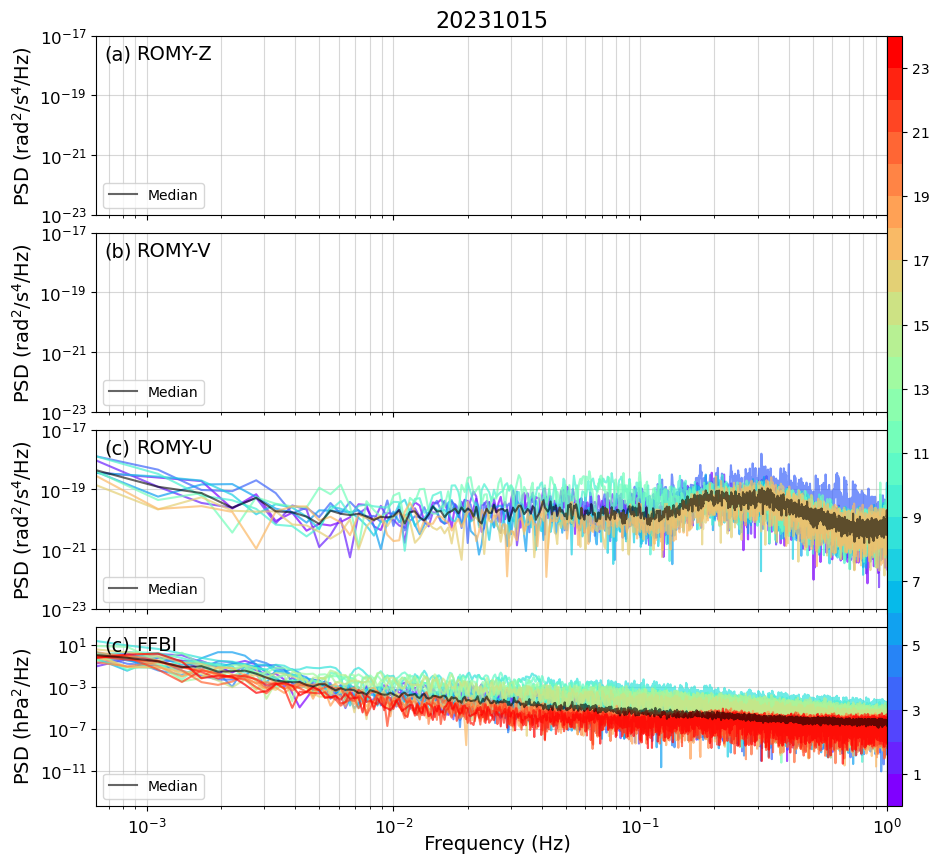

 -> saving: /import/kilauea-data/LNM2/figures/joint_20231015.png
[Errno 2] No such file or directory: '/import/kilauea-data/LNM2/PSDS/ROMY/2023_ROMY_Z_3600_20231016_hourly.pkl'
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
[Errno 2] No such file or directory: '/import/kilauea-data/LNM2/PSDS/ROMY/2023_ROMY_U_3600_20231017_hourly.pkl'
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
[Errno 2] No such file or directory: '/import/kilauea-data/LNM2/PSDS/ROMY/2023_ROMY_U_3600_20231018_hourly.pkl'
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
[Errno 2] No such file or directory: '/import/kilauea-data/LNM2/PSDS/ROMY/2023_ROMY_U_3600_20231019_hourly.pkl'
 -> removed 0 rows due to mean thresholds!
 -> 24 psds remain
 -> removed 0 rows due to mean thresholds!
 -> 24 psd

/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


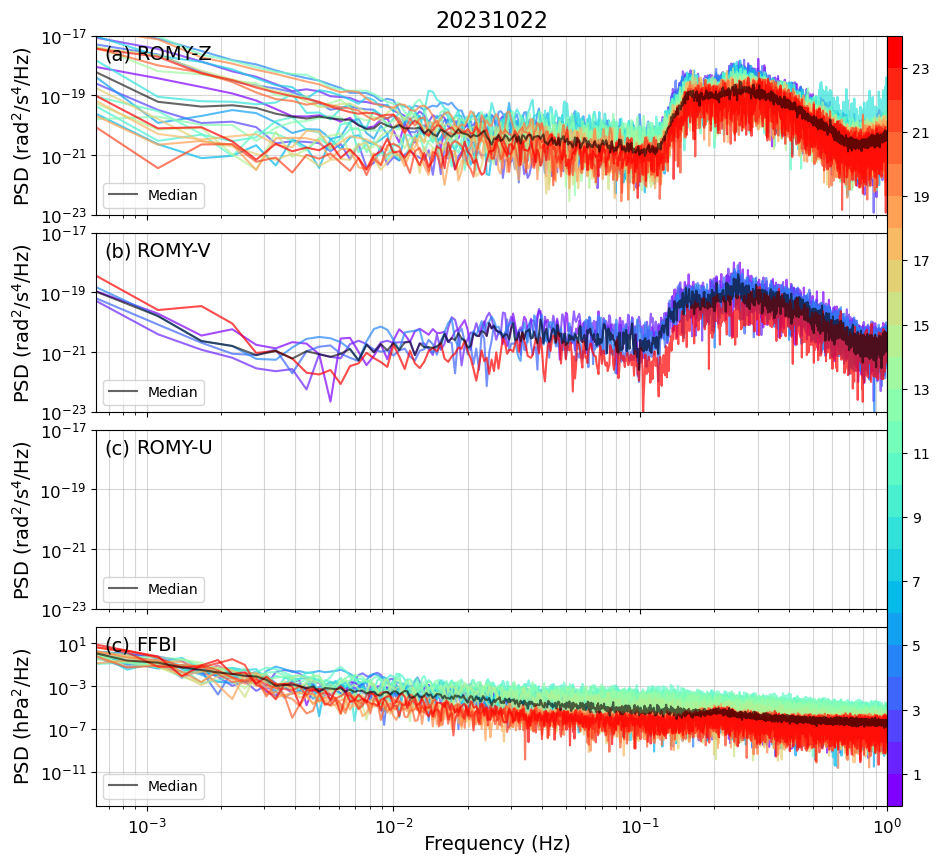

 -> saving: /import/kilauea-data/LNM2/figures/joint_20231022.png
[Errno 2] No such file or directory: '/import/kilauea-data/LNM2/PSDS/ROMY/2023_ROMY_Z_3600_20231023_hourly.pkl'


In [21]:
config['files'] = [file for file in os.listdir(config['inpath']) if "hourly" in file]
config['files'].sort()


psds_medians_out, times_out = [],[]

for _i, day in enumerate(date_range(d1, d2)):

    day = str(day).split(" ")[0].replace("-", "")

    config['outpath_figname'] = "joint_"+day

    # if _i > 1:
    #     continue

    # if os.path.isfile(config['outpath_figures']+config['outpath_figname']):
    #     print(f" -> skipping {file} ...")
    #     continue


    try:

        ## Data1 --------------------------
        name = "ROMY/2023_ROMY_Z"
        ff1 = pickle.load(open(path+f"{name}_3600_frequency_axis.pkl", 'rb'))
        dat1 = __load_data_file(path,f"{name}_3600_{day}_hourly.pkl")
        dat1, rejected_dat1 = __remove_noisy_psds(dat1, threshold_mean=1e-19, ff=ff1, flim=0.05)
        # dat1, ff1 = __cut_frequencies_array(dat1, ff1, config['frequency_limits'][0], config['frequency_limits'][1])

        ## Data2 --------------------------
        name = "ROMY/2023_ROMY_V"
        ff2 = pickle.load(open(path+f"{name}_3600_frequency_axis.pkl", 'rb'))
        dat2 = __load_data_file(path,f"{name}_3600_{day}_hourly.pkl")
        dat2, rejected_dat2 = __remove_noisy_psds(dat2, threshold_mean=1e-19, ff=ff1, flim=0.05)
        # dat2, ff2 = __cut_frequencies_array(dat2, ff2, config['frequency_limits'][0], config['frequency_limits'][1])

        ## Data3 --------------------------
        name = "ROMY/2023_ROMY_U"
        ff3 = pickle.load(open(path+f"{name}_3600_frequency_axis.pkl", 'rb'))
        dat3 = __load_data_file(path,f"{name}_3600_{day}_hourly.pkl")
        dat3, rejected_dat3 = __remove_noisy_psds(dat3, threshold_mean=1e-19, ff=ff1, flim=0.05)
        # dat3, ff3 = __cut_frequencies_array(dat3, ff3, config['frequency_limits'][0], config['frequency_limits'][1])


        ## Data4 --------------------------
        name = "FFBI_absolute/2023_FFBI"
        ff4 = pickle.load(open(path+f"{name}_3600_frequency_axis.pkl", 'rb'))
        dat4 = __load_data_file(path,f"{name}_3600_{day}_hourly.pkl")
        dat4, rejected_dat4 = __remove_noisy_psds(dat4, threshold_mean=1e15, ff=ff1, flim=0.05)
        # dat4, ff4 = __cut_frequencies_array(dat4, ff4, config['frequency_limits'][0], config['frequency_limits'][1])


        ## FURT --------------------------
        # ff_furt = pickle.load(open(path+f"FURT/2023_FURT_3600_frequency_axis.pkl", 'rb'))
        # furt = __load_data_file(path,f"FURT/2023_FURT_3600_{day}_hourly.pkl")
        # furt, rejected_furt = __remove_noisy_psds(furt, threshold_mean=1e2)
        # furt, ff_furt = __cut_frequencies_array(furt, ff_furt, config['frequency_limits'][0], config['frequency_limits'][1])


    except Exception as e:
        print(e)
        continue


    fig = __makeplot_colorlines_overview(config,
                                         [ff1, ff2, ff3, ff4],
                                         [dat1, dat2, dat3, dat4],
                                         [rejected_dat1, rejected_dat2, rejected_dat3, rejected_dat4],
                                         day,
                                         show_rejected=True)

    print(f" -> saving: {config['outpath_figures']}{config['outpath_figname']}.png")
    fig.savefig(config['outpath_figures']+"joint/"+config['outpath_figname']+".png", format="png", transparent=False, bbox_inches='tight', dpi=200)

In [22]:
    ## output data
#     psds_medians_out.append(psds_median)
#     times_out.append(time)

# ## write output
# output = {"times": array(times_out).astype(int), "frequencies": array(ff), "psds_medians": array(psds_medians_out)}

# with open(f"{config['inpath']}{config['inname']}_psds_filtered_medians.pkl", 'wb') as file:
#     pickle.dump(output, file, protocol=pickle.HIGHEST_PROTOCOL)